# Garch model experiment 01

In [10]:
import os
import sys
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from arch import arch_model
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=13)
plt.style.use('seaborn-v0_8-pastel')
sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', None)

In [11]:
TICKER = "BTC-USD"
DATA_DIR = "data_hourly"
FILE_PATH = os.path.join("..", "data", f"{DATA_DIR}", f"{TICKER}_hourly.csv")

In [12]:
try:
    df_raw = pd.read_csv(
        FILE_PATH,
        header=0,           
        skiprows=[1, 2],           
        parse_dates=True    
    )
    print(f"Данные для {TICKER} успешно загружены.")
except FileNotFoundError:
    print(f"Ошибка: Файл не найден по пути {FILE_PATH}. Убедитесь, что вы запустили скрипт скачивания.")
    exit()

Данные для BTC-USD успешно загружены.


In [13]:
df = df_raw.rename(columns={'Price': 'Datetime'})

df['Datetime'] = pd.to_datetime(df['Datetime'])

df.set_index('Datetime', inplace=True)

In [14]:
print(df.shape)
df.head()

(17491, 5)


,Close,High,Low,Open,Volume
Datetime,,,,,
2023-09-19 21:00:00+00:00,27159.375000,27191.607422,27036.193359,27190.554688,0
2023-09-19 22:00:00+00:00,27200.597656,27202.234375,27114.068359,27161.826172,0
2023-09-19 23:00:00+00:00,27215.648438,27229.179688,27183.535156,27199.613281,0
2023-09-20 00:00:00+00:00,27180.017578,27255.080078,27163.093750,27210.228516,0
2023-09-20 01:00:00+00:00,27349.701172,27349.701172,27210.154297,27210.154297,149042176


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17491 entries, 2023-09-19 21:00:00+00:00 to 2025-09-17 17:00:00+00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   17491 non-null  float64
 1   High    17491 non-null  float64
 2   Low     17491 non-null  float64
 3   Open    17491 non-null  float64
 4   Volume  17491 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 819.9 KB


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,17491.0,7.428472e+04,2.607076e+04,26063.386719,57898.847656,68251.796875,9.744454e+04,1.238109e+05
High,17491.0,7.449485e+04,2.612731e+04,26102.777344,58126.357422,68441.929688,9.767384e+04,1.243223e+05
Low,17491.0,7.406306e+04,2.601383e+04,26011.468750,57701.945312,68074.171875,9.716307e+04,1.234140e+05
Open,17491.0,7.427909e+04,2.607069e+04,26059.931641,57894.570312,68255.609375,9.741800e+04,1.238693e+05
Volume,17491.0,4.338545e+08,1.117185e+09,0.000000,0.000000,0.000000,4.723487e+08,3.461036e+10


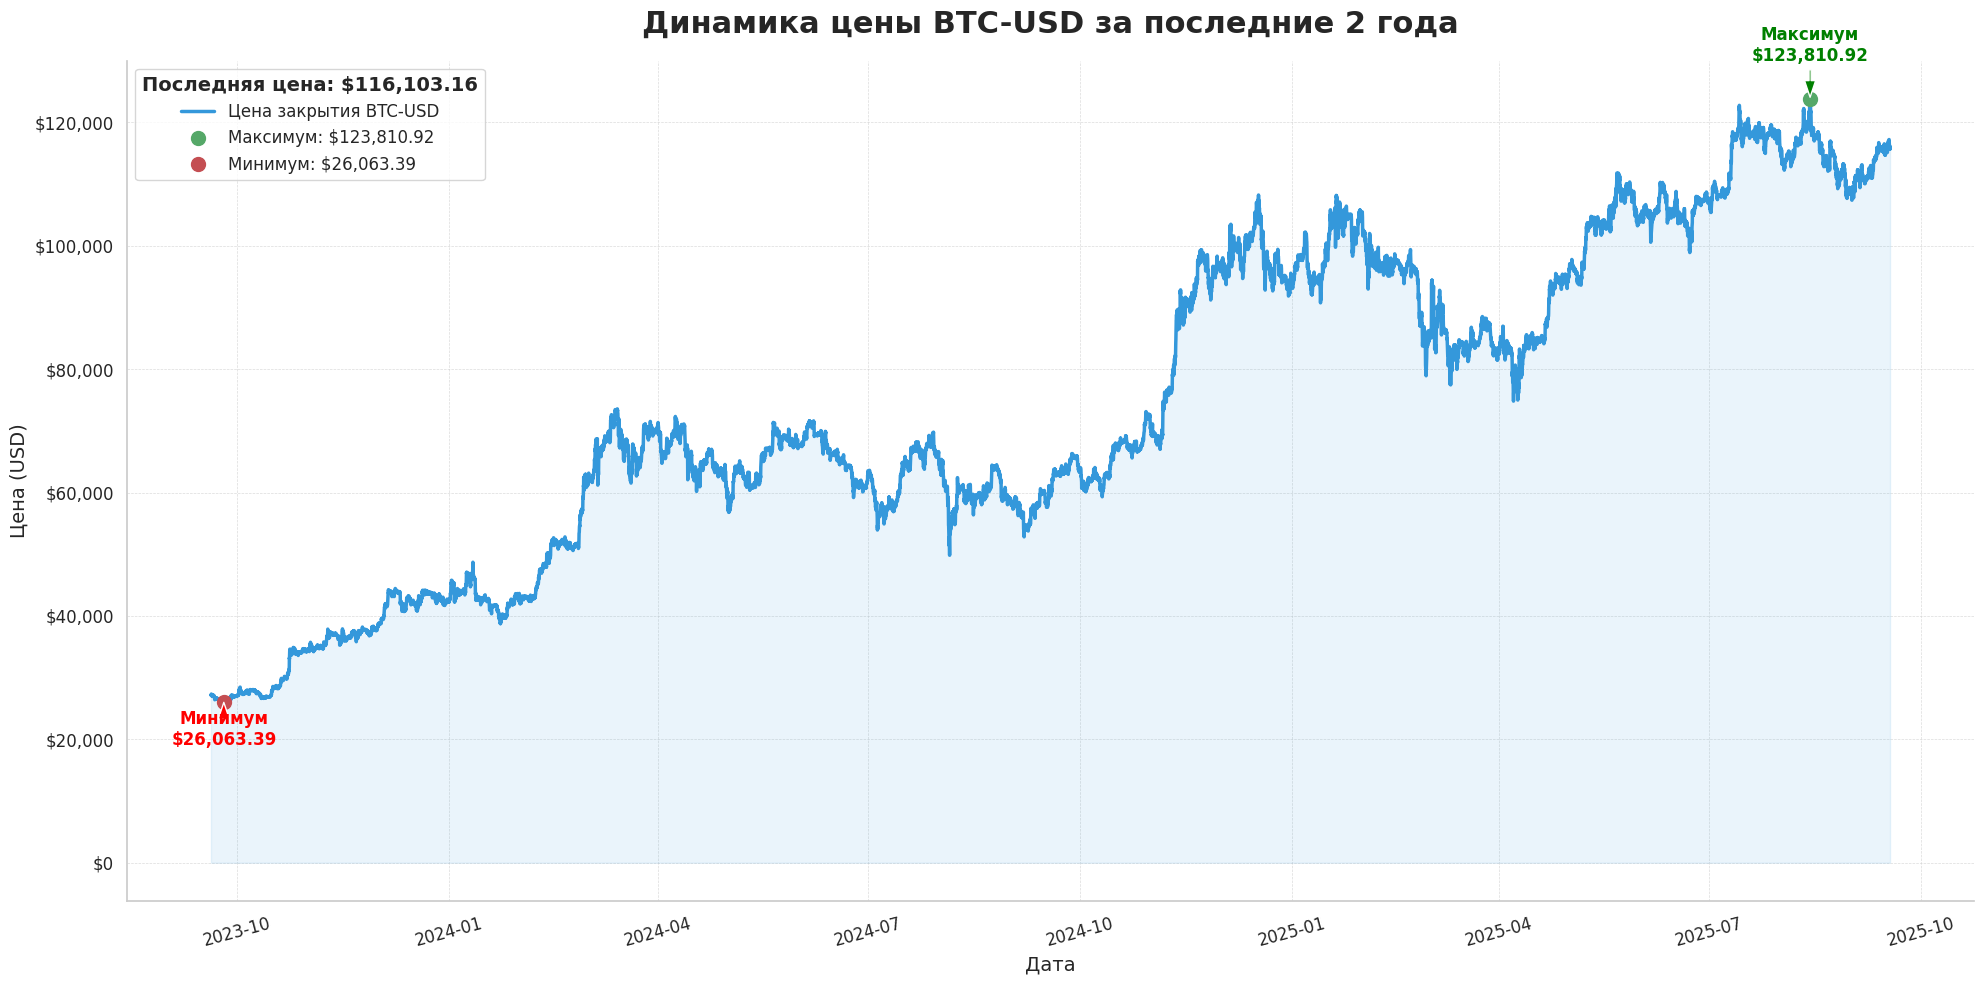

In [17]:
# ==============================================================================
# Визуализация цены закрытия
# ==============================================================================

from matplotlib.ticker import FuncFormatter

max_price = df['Close'].max()
max_date = df['Close'].idxmax()
min_price = df['Close'].min()
min_date = df['Close'].idxmin()
last_price = df['Close'][-1]

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df.index, df['Close'], color='#3498db', linewidth=2.5, label=f'Цена закрытия {TICKER}')

ax.fill_between(df.index, df['Close'], color='#3498db', alpha=0.1)

ax.plot(max_date, max_price, 'go', markersize=10, label=f'Максимум: ${max_price:,.2f}')
ax.annotate(f'Максимум\n${max_price:,.2f}',
            xy=(max_date, max_price),
            xytext=(max_date, max_price * 1.05), # Располагаем текст чуть выше точки
            arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8),
            fontsize=12,
            fontweight='bold',
            ha='center',
            color='green')

ax.plot(min_date, min_price, 'ro', markersize=10, label=f'Минимум: ${min_price:,.2f}')
ax.annotate(f'Минимум\n${min_price:,.2f}',
            xy=(min_date, min_price),
            xytext=(min_date, min_price * 0.95), 
            arrowprops=dict(facecolor='red', shrink=0.05, width=1.5, headwidth=8),
            fontsize=12,
            fontweight='bold',
            ha='center',
            va='top',
            color='red')

ax.set_title(f'Динамика цены {TICKER} за последние 2 года', fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Цена (USD)', fontsize=14)

ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
ax.spines['top'].set_visible(False)   
ax.spines['right'].set_visible(False) 
ax.tick_params(axis='x', rotation=15, labelsize=12) 
ax.tick_params(axis='y', labelsize=12)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))

legend = ax.legend(title=f'Последняя цена: ${last_price:,.2f}', loc='upper left', fontsize=12)
plt.setp(legend.get_title(),fontsize='14', fontweight='bold')

plt.tight_layout();

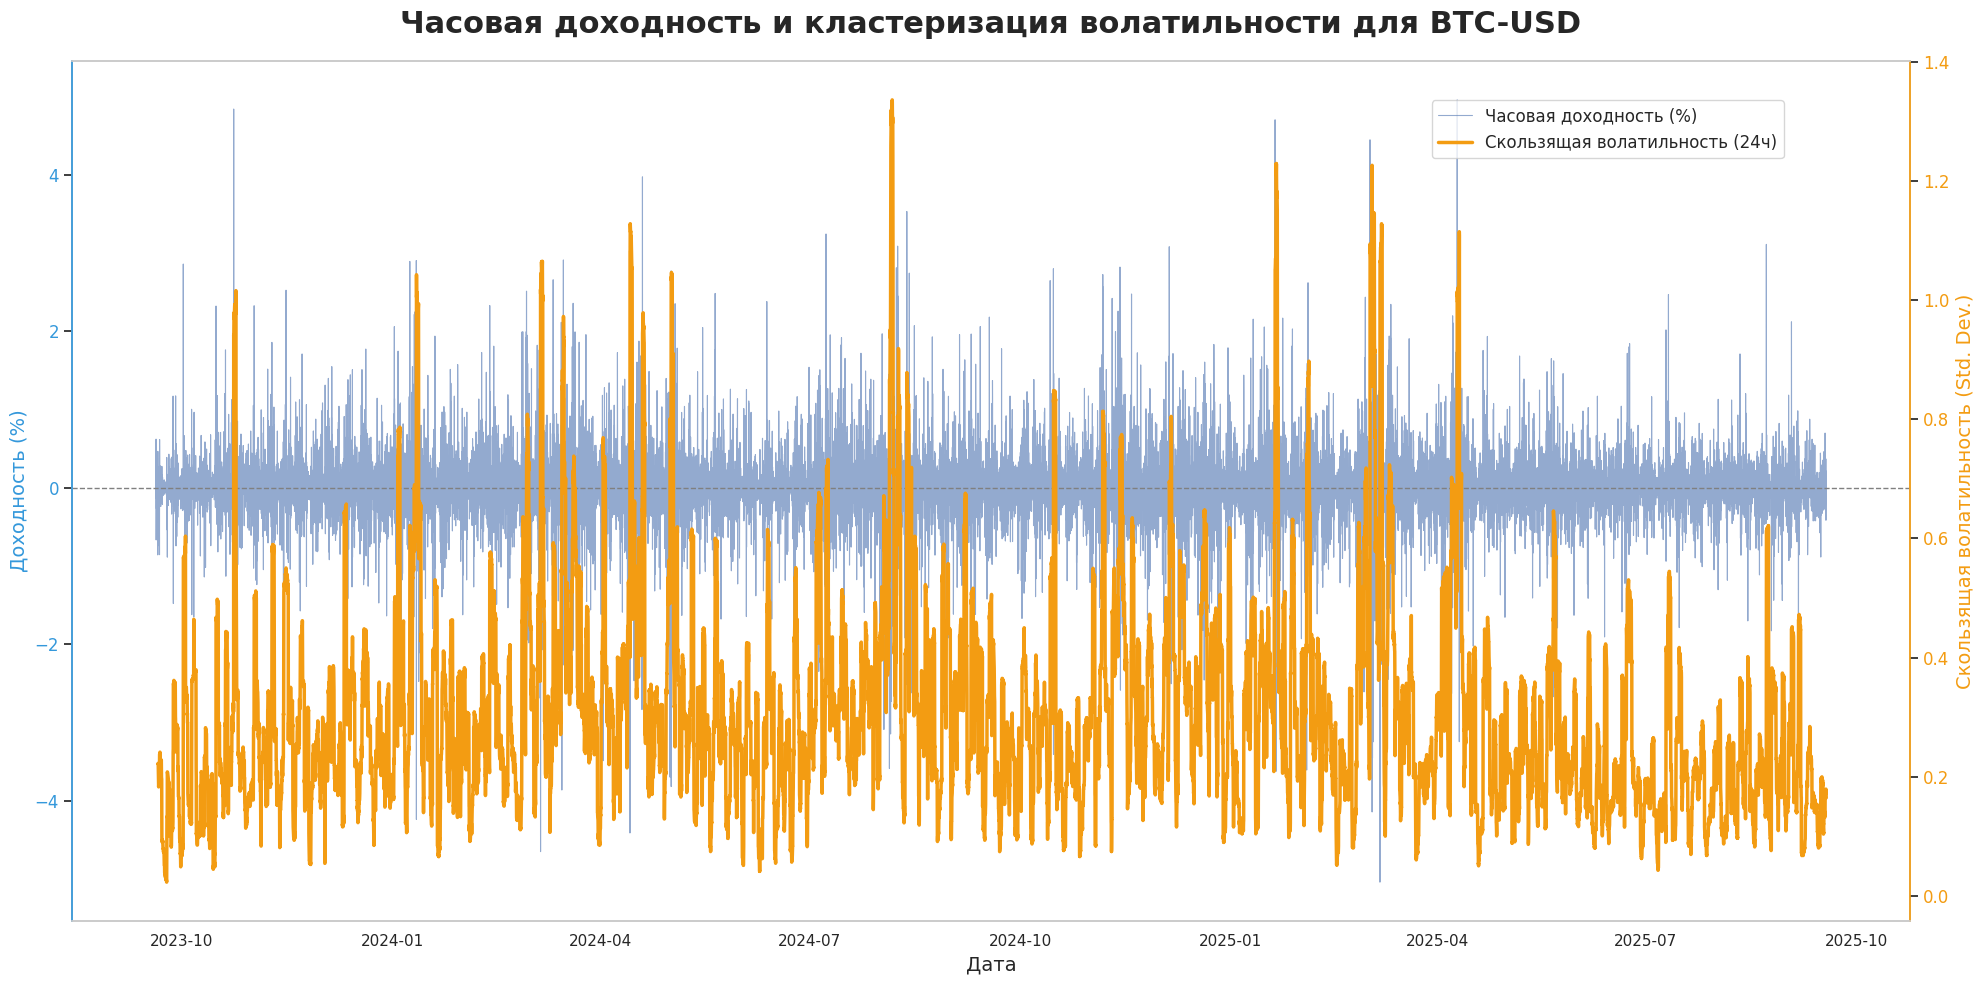

In [18]:
# ==============================================================================
# Динамика доходности
# ==============================================================================

# Рассчитываем скользящую волатильность (стандартное отклонение доходности за сутки)
# Мы берем модуль доходности, чтобы усреднять "силу" колебаний, а не их направление.
df['returns'] = 100 * np.log(df['Close']).diff()
rolling_volatility = df['returns'].abs().rolling(window=24).std()
df.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df.index, df['returns'], linewidth=0.8, alpha=0.6, label='Часовая доходность (%)')
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Доходность (%)', fontsize=14, color='#3498db')
ax.tick_params(axis='y', labelcolor='#3498db', labelsize=12)

ax.axhline(0, color='grey', linestyle='--', linewidth=1)

ax2 = ax.twinx()
ax2.plot(rolling_volatility.index, rolling_volatility, color='#f39c12', linewidth=2.5, label='Скользящая волатильность (24ч)')
ax2.set_ylabel('Скользящая волатильность (Std. Dev.)', fontsize=14, color='#f39c12')
ax2.tick_params(axis='y', labelcolor='#f39c12', labelsize=12)
ax2.spines['right'].set_color('#f39c12')
ax2.spines['left'].set_color('#3498db')

ax.set_title(f'Часовая доходность и кластеризация волатильности для {TICKER}', fontsize=22, fontweight='bold', pad=20)
ax.grid(False)
ax2.grid(False)

fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9), fontsize=12)

plt.tight_layout();

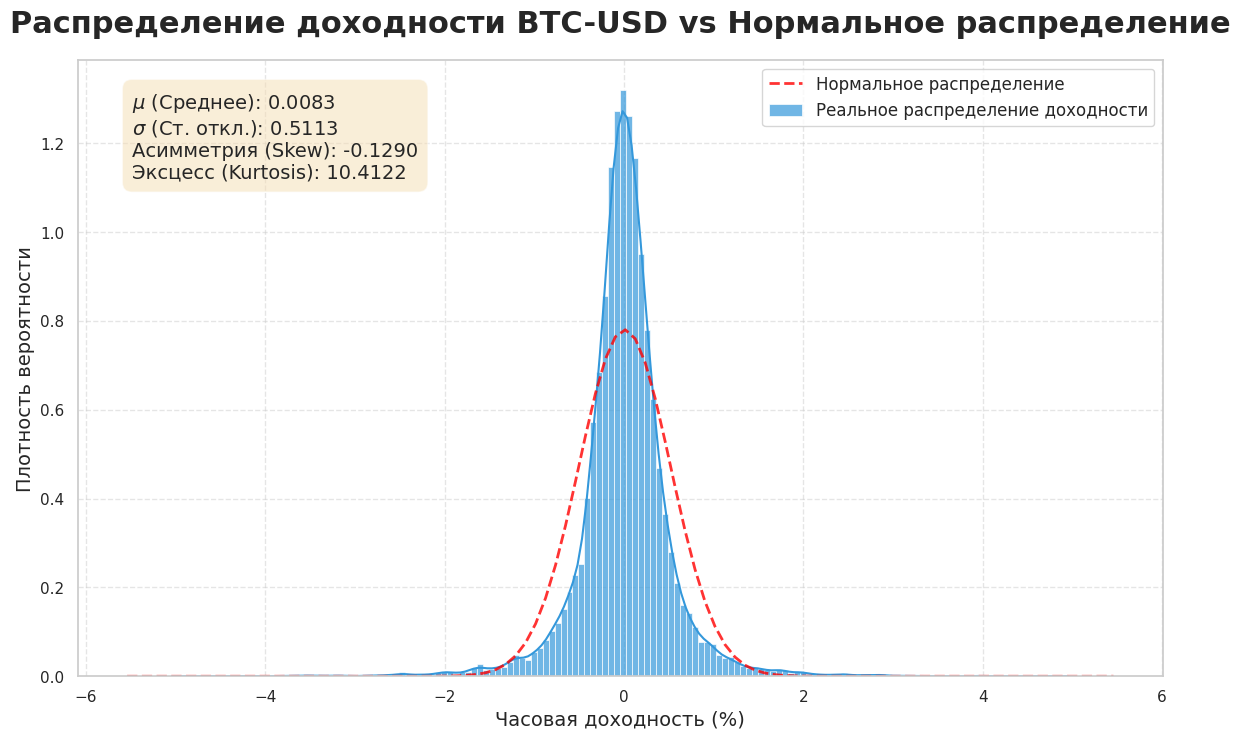

In [19]:
# ==============================================================================
# Распределение доходности
# ==============================================================================
from scipy.stats import norm

mu = df['returns'].mean()
sigma = df['returns'].std()
skew = df['returns'].skew()
kurtosis = df['returns'].kurtosis() # Pandas возвращает эксцесс (Kurtosis - 3)

plt.figure(figsize=(14, 8))

sns.histplot(df['returns'], bins=150, kde=True, stat='density',
             color='#3498db', alpha=0.7, label='Реальное распределение доходности')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k--', linewidth=2, color='red', alpha=0.8, label='Нормальное распределение')

stats_text = (
    f"$\mu$ (Среднее): {mu:.4f}\n"
    f"$\sigma$ (Ст. откл.): {sigma:.4f}\n"
    f"Асимметрия (Skew): {skew:.4f}\n"
    f"Эксцесс (Kurtosis): {kurtosis:.4f}"
)
plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))


plt.title(f'Распределение доходности {TICKER} vs Нормальное распределение', fontsize=22, fontweight='bold', pad=20)
plt.xlabel('Часовая доходность (%)', fontsize=14)
plt.ylabel('Плотность вероятности', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -8849.32
Distribution:      Standardized Student's t   AIC:                           17708.6
Method:                  Maximum Likelihood   BIC:                           17747.5
                                              No. Observations:                17490
Date:                      Wed, Sep 17 2025   Df Residuals:                    17489
Time:                              21:03:50   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

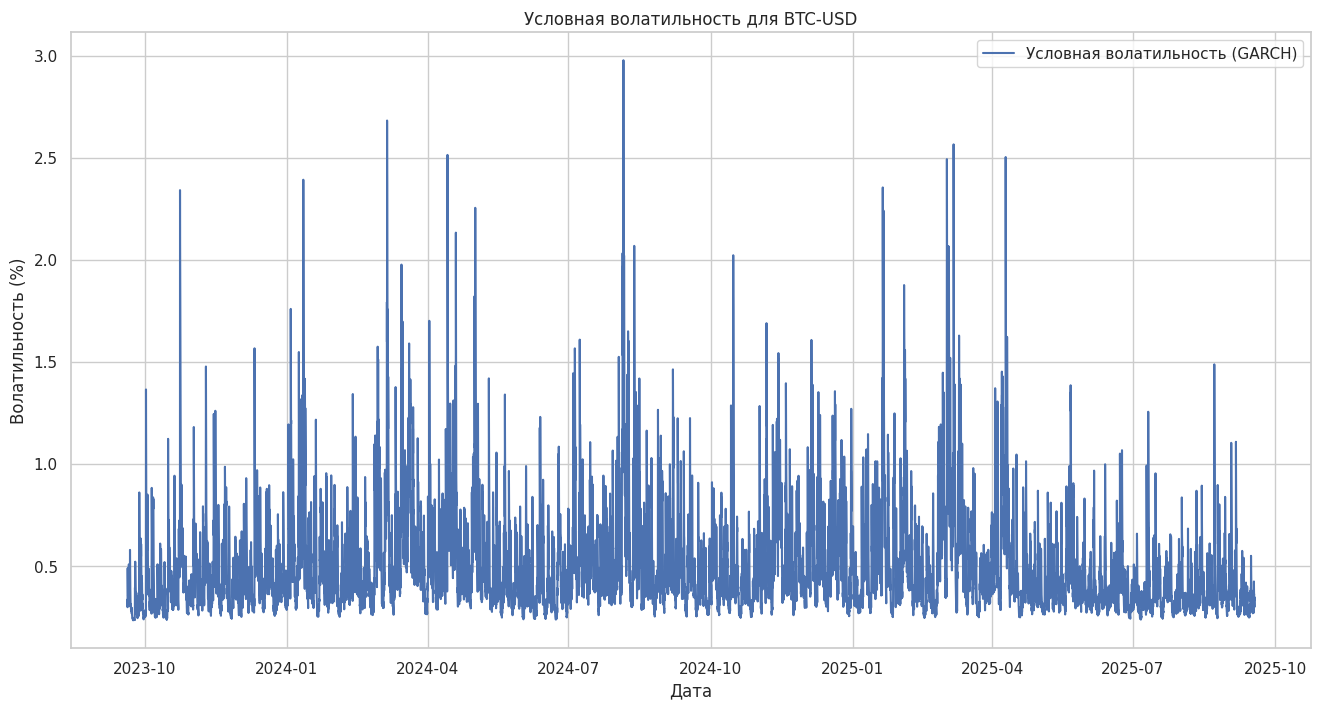

In [20]:
# ==============================================================================
# Моделирование волатильности с помощью GARCH(1,1)
# ==============================================================================

# Создаем модель GARCH(1,1) с t-распределением Стьюдента
# p=1, q=1 - стандартные параметры для GARCH
# dist='t' - указывает на использование t-распределения
model = arch_model(df['returns'], vol='Garch', p=1, q=1, dist='t')

# Обучаем модель на наших данных
# update_freq=10 - просто для красивого вывода процесса обучения
results = model.fit(update_freq=10, disp='off')

print(results.summary())

plt.figure(figsize=(16, 8))
plt.plot(results.conditional_volatility, label='Условная волатильность (GARCH)')
plt.title(f'Условная волатильность для {TICKER}')
plt.ylabel('Волатильность (%)')
plt.xlabel('Дата')
plt.legend()
plt.show()

In [21]:
def fit_garch_model(historical_returns):
    """
    Обучает модель GARCH(1,1) на временном ряде доходности.

    Args:
        historical_returns (pd.Series): Временной ряд часовой доходности.

    Returns:
        arch.arch_model.ARCHModelResult: Обученная модель GARCH.
    """
    print("[Этап 1] Обучение модели GARCH(1,1)...")
    
    # Мы используем стандартную конфигурацию GARCH(1,1), так как она наиболее
    # распространена и эффективна для финансовых временных рядов.
    # dist='t' (t-распределение Стьюдента) выбрано для лучшего учета
    # "тяжелых хвостов" в распределении доходности.
    model = arch_model(historical_returns, vol='Garch', p=1, q=1, dist='t')
    
    # Обучаем модель, отключая вывод лога процесса обучения (disp='off')
    results = model.fit(disp='off')
    
    print("Модель успешно обучена.")
    print(results.summary())
    
    return results

In [22]:
def forecast_garch_volatility(model_results, forecast_horizon_hours):
    """
    Прогнозирует волатильность с помощью обученной модели GARCH.

    Args:
        model_results (arch.arch_model.ARCHModelResult): Обученная модель.
        forecast_horizon_hours (int): Горизонт прогнозирования в часах.

    Returns:
        np.array: Массив с прогнозируемыми значениями волатильности.
    """
    print(f"\n[Этап 2] Прогнозирование волатильности на {forecast_horizon_hours} часов вперед...")
    
    # Используем метод .forecast() для получения прогноза
    forecasts = model_results.forecast(horizon=forecast_horizon_hours, reindex=False)
    
    # Извлекаем прогнозируемую дисперсию (variance)
    forecasted_variance = forecasts.variance.values[-1, :]
    
    # Преобразуем дисперсию в волатильность (стандартное отклонение), взяв квадратный корень
    forecasted_volatility = np.sqrt(forecasted_variance)
    
    print("Прогноз волатильности успешно построен.")
    
    return forecasted_volatility

In [23]:
def run_monte_carlo_simulation(last_price, forecasted_vol, horizon_hours, num_simulations):
    """
    Запускает симуляцию Монте-Карло для прогнозирования цены.

    Args:
        last_price (float): Последняя известная цена актива.
        forecasted_vol (np.array): Массив прогнозной волатильности от GARCH.
        horizon_hours (int): Горизонт симуляции в часах.
        num_simulations (int): Количество симулируемых траекторий цены.

    Returns:
        np.array: 2D-массив с симулированными траекториями цен.
    """
    print(f"\n[Этап 3] Запуск симуляции Монте-Карло ({num_simulations} траекторий)...")
    
    # Создаем 2D-массив для хранения симулированных доходностей
    # Размер: (горизонт) x (количество симуляций)
    sim_returns = np.zeros((horizon_hours, num_simulations))
    
    # Для каждого часа в будущем мы используем его собственную прогнозную волатильность
    # Это ключевое отличие от простой симуляции с постоянной волатильностью.
    for t in range(horizon_hours):
        # Генерируем случайные шоки из нормального распределения
        # Делим волатильность на 100, чтобы перевести из процентов в десятичные дроби
        vol_t = forecasted_vol[t] / 100.0
        sim_returns[t, :] = np.random.normal(0, vol_t)
        
    # Создаем массив для хранения траекторий цен
    # Размер: (горизонт + 1) x (количество симуляций)
    sim_prices = np.zeros((horizon_hours + 1, num_simulations))
    
    # Первая цена для всех траекторий - это последняя известная цена
    sim_prices[0, :] = last_price
    
    # Преобразуем доходности в цены
    for t in range(horizon_hours):
        sim_prices[t + 1, :] = sim_prices[t, :] * (1 + sim_returns[t, :])
        
    print("Симуляция завершена.")
    
    return sim_prices

In [24]:
def analyze_simulation_results(sim_prices, last_price, confidence_level=0.95):
    """
    Анализирует результаты симуляции и рассчитывает метрики риска.

    Args:
        sim_prices (np.array): 2D-массив с симулированными траекториями цен.
        last_price (float): Последняя известная цена актива.
        confidence_level (float): Уровень доверия для расчета VaR (например, 0.95 для 95%).

    Returns:
        dict: Словарь с ключевыми метриками анализа.
    """
    print("\n[Этап 4] Анализ результатов и расчет метрик риска...")
    
    # Извлекаем цены на конец прогнозного периода
    final_prices = sim_prices[-1, :]
    
    # Расчет VaR
    # VaR - это перцентиль распределения конечных цен.
    # Для 95% доверия мы берем 5-й перцентиль (100 - 95 = 5).
    var_percentile = 100 * (1 - confidence_level)
    var_price = np.percentile(final_prices, var_percentile)
    
    # Расчет других метрик
    results = {
        'last_price': last_price,
        'confidence_level': confidence_level,
        'final_prices': final_prices,
        'VaR_price': var_price,
        'expected_loss': last_price - var_price,
        'median_forecast': np.median(final_prices),
        'mean_forecast': np.mean(final_prices),
        'prob_gain': np.mean(final_prices > last_price) * 100
    }
    
    print("Анализ завершен.")
    return results

In [ ]:
if __name__ == '__main__':
    FORECAST_HORIZON_HOURS = 24 * 7  # 1 неделя
    NUM_SIMULATIONS = 1000           # Количество траекторий Монте-Карло
    CONFIDENCE_LEVEL = 0.95          # Уровень доверия для VaR
    
    
    garch_results = fit_garch_model(df['returns'])
    
    forecasted_vol = forecast_garch_volatility(garch_results, FORECAST_HORIZON_HOURS)
    
    last_known_price = df['Close'][-1]
    simulated_prices = run_monte_carlo_simulation(last_known_price, forecasted_vol, FORECAST_HORIZON_HOURS, NUM_SIMULATIONS)
    
    analysis_metrics = analyze_simulation_results(simulated_prices, last_known_price, CONFIDENCE_LEVEL)

    print("\n" + "="*60)
    print("             КЛЮЧЕВЫЕ РЕЗУЛЬТАТЫ АНАЛИЗА РИСКОВ")
    print("="*60)
    print(f"Актив: {TICKER}")
    print(f"Горизонт прогнозирования: {FORECAST_HORIZON_HOURS} часов ({FORECAST_HORIZON_HOURS/24:.0f} дней)")
    print(f"Последняя цена: ${analysis_metrics['last_price']:,.2f}")
    print("-"*60)
    print(f"Медианный прогноз цены: ${analysis_metrics['median_forecast']:,.2f}")
    print(f"Вероятность роста цены: {analysis_metrics['prob_gain']:.2f}%")
    print("-"*60)
    print(f"Value at Risk ({analysis_metrics['confidence_level']:.0%}):")
    print(f"  Цена не упадет ниже ${analysis_metrics['VaR_price']:,.2f} с вероятностью {analysis_metrics['confidence_level']:.0%}.")
    print(f"  Максимальный ожидаемый убыток: ${analysis_metrics['expected_loss']:,.2f}")
    print("="*60)

[Этап 1] Обучение модели GARCH(1,1)...
Модель успешно обучена.
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -8849.32
Distribution:      Standardized Student's t   AIC:                           17708.6
Method:                  Maximum Likelihood   BIC:                           17747.5
                                              No. Observations:                17490
Date:                      Wed, Sep 17 2025   Df Residuals:                    17489
Time:                              21:03:52   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------